<a href="https://colab.research.google.com/github/jfvandem/dev_test_days/blob/master/intro_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dev test days 2019 - Meylan

basé sur https://www.kaggle.com/c/ashrae-energy-prediction/data

https://www.tensorflow.org/tutorials/keras/regression
https://www.tensorflow.org/tutorials/structured_data/time_series
https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series


# Clone github

In [57]:
!rm -rf dev_test_days
!git clone https://github.com/jfvandem/dev_test_days

Cloning into 'dev_test_days'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 124 (delta 22), reused 0 (delta 0), pack-reused 82
Receiving objects: 100% (124/124), 131.34 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Import

In [0]:
import gc
import glob
import io
import itertools
import joblib
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import re
import requests
import seaborn as sns
import tensorflow as tf
import time
import warnings
import zipfile

from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
from math import sqrt
from matplotlib.collections import PatchCollection
from nltk.tokenize import word_tokenize
from os import path

from scipy import stats
from scipy.stats import skew

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

warnings.filterwarnings("ignore")

In [60]:
print(tf.__version__)

2.0.0


In [0]:
RANDOM_SEED = 42

tf.random.set_seed(RANDOM_SEED)

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Chargement des données

In [63]:
!ls dev_test_days

dataset  intro_deep_learning.ipynb  README.md


In [0]:
data_dir='dev_test_days/dataset/'

In [65]:
df = pd.read_pickle(data_dir+'train_full_df.pkl.zip',compression='zip')
df.shape
df.head()

(6634879, 23)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
0,0,0,2016-01-01,0.0,0,0,7432,2008,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
2,2,0,2016-01-01,0.0,0,0,5376,1991,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
6,6,0,2016-01-01,0.0,0,4,27926,1981,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
7,7,0,2016-01-01,0.0,0,0,121074,1989,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
9,9,0,2016-01-01,0.0,0,6,27000,2010,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1


In [66]:
le=joblib.load(data_dir+'label_encoder.pkl')
le.classes_

array(['Education', 'Entertainment/public assembly',
       'Food sales and service', 'Healthcare', 'Lodging/residential',
       'Manufacturing/industrial', 'Office', 'Other', 'Parking',
       'Public services', 'Religious worship', 'Retail', 'Services',
       'Technology/science', 'Utility', 'Warehouse/storage'], dtype=object)

In [0]:
df['primary_use_label']=le.inverse_transform(df['primary_use'])

In [68]:
len(df.columns)
df.columns

24

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'primary_use_label'],
      dtype='object')

#Echantillonnage
Nous sélectionnons les batiments pour que l'apprentissage du modèle soit réalisé dans un temps raisonnable. Nous conservons uniquement les mesures réalisées sur le compteur d'électricité

In [69]:
df['primary_use_label'].drop_duplicates()

0                           Education
6                 Lodging/residential
9                              Office
42                             Retail
49                            Parking
144                   Public services
170     Entertainment/public assembly
178                 Warehouse/storage
214            Food sales and service
228                 Religious worship
278                        Healthcare
442                           Utility
665                             Other
1235                         Services
1407               Technology/science
2120         Manufacturing/industrial
Name: primary_use_label, dtype: object

In [70]:
df.shape
df=df[(df['primary_use_label']=='Office')&(df['meter']==0)]
df.shape

(6634879, 24)

(850271, 24)

In [71]:
top5_building_id=df.groupby('building_id')['meter_reading'].count().sort_values(ascending=False).reset_index().head(5)['building_id']
top5_building_id

0       9
1     143
2    1151
3    1129
4    1127
Name: building_id, dtype: uint64

In [72]:
df.shape
df=df[df['building_id'].isin(top5_building_id)]
df.shape

(850271, 24)

(43920, 24)

In [73]:
df['meter'].value_counts()

0    43920
Name: meter, dtype: int64

In [74]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2016-01-01 00:00:00
2016-12-31 23:00:00


In [75]:
print('fréquence des mesures : {}'.format(df.groupby('timestamp')['meter_reading'].mean().index.inferred_freq))

fréquence des mesures : H


# Description des colonnes


* air_temperature : température de l'air (degré Celsius)
* building_id : foreign key pour les données sur les immeubles (building_metadata)
* cloud_coverage : couverture nuageuse (oktas)
* dew température : température de rosée (degré Celsius)
* floor_count : nombre d'étages dans l'immeuble
* meter : code du type de compteur {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Tous les immeubles n'ont pas tous les types de compteur
* meter_reading : Consommation d'énergie en kWh (avec erreurs de mesure possibles) (la "**target**")
* precip_depth_1_hr : hauteur de précipitation en 1h (millimètre)
* primary_use : indicateur de l'activité des occupants dans l'immeuble selon la définition EnergyStar
* sea_level_pressure : pression au niveau de la mer (Millibar/hectopascals)
* site_id : foreign key pour les données météo
* square_feet : surface au plancher de l'immeuble (pied carré)
* timestamp : date à laquelle la mesure a été prise. Le timestamp a été "éclaté" en plusieurs champs (heure, jour, année, jour dans la semaine...)
* wind_direction : direction du vent (0 à 360 degré)
* wind_speed : vitesse du vent (m/s)
* year_built : année de construction de l'immeuble



In [76]:
# Valeurs manquantes (substitution réalisée dans le preprocessing, -1 ou moyenne)
df.isna().sum()

building_id            0
meter                  0
timestamp              0
meter_reading          0
site_id                0
primary_use            0
square_feet            0
year_built             0
floor_count            0
air_temperature        0
cloud_coverage         0
dew_temperature        0
precip_depth_1_hr      0
sea_level_pressure     0
wind_direction         0
wind_speed             0
month_datetime         0
weekofyear_datetime    0
dayofyear_datetime     0
hour_datetime          0
day_week               0
day_month_datetime     0
week_month_datetime    0
primary_use_label      0
dtype: int64

#Data Visualisation

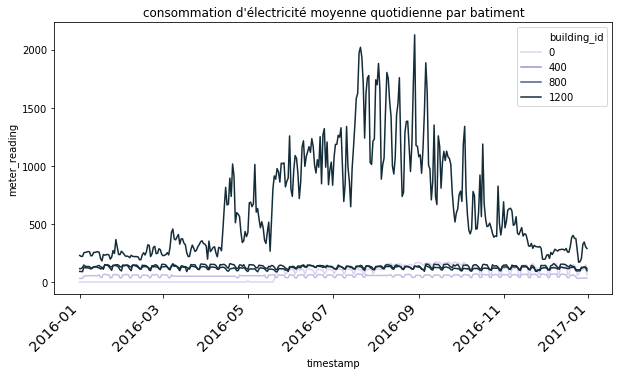

In [77]:

d=df.set_index('timestamp').groupby(['building_id']).resample('D')['meter_reading'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x='timestamp',y='meter_reading',data=d,hue='building_id',palette='ch:2.5,.25').set_title('consommation d\'électricité moyenne quotidienne par batiment')

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);



# Features

In [0]:
feature_cols=['primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'month_datetime',
 'weekofyear_datetime',
 'dayofyear_datetime',
 'hour_datetime',
 'day_week',
 'day_month_datetime',
 'week_month_datetime']
target_col='meter_reading'

#Train / test split

In [79]:
train_df=df[df['timestamp'].dt.month<11]
test_df=df[df['timestamp'].dt.month>=11]

train_df.shape
test_df.shape

(36600, 24)

(7320, 24)

#Normalisation des données

cf. https://jovianlin.io/why-is-normalization-important-in-neural-networks/

In [80]:
train_stats = train_df[feature_cols].describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
primary_use,36600.0,6.000000,0.000000,6.0,6.00,6.0,6.00,6.0
square_feet,36600.0,110970.400000,86772.829762,27000.0,40085.00,87131.0,133100.00,267536.0
year_built,36600.0,401.200000,804.410989,-1.0,-1.00,-1.0,-1.00,2010.0
floor_count,36600.0,0.000000,2.000027,-1.0,-1.00,-1.0,-1.00,4.0
air_temperature,36600.0,13.958333,10.884430,-25.0,7.00,16.0,22.00,36.0
cloud_coverage,36600.0,0.703880,2.531188,-1.0,-1.00,-1.0,2.00,9.0
dew_temperature,36600.0,7.870137,10.298801,-29.0,1.00,10.0,16.00,25.0
precip_depth_1_hr,36600.0,0.674617,8.821998,-1.0,-1.00,0.0,0.00,343.0
sea_level_pressure,36600.0,1003.914044,107.471605,-1.0,1011.00,1016.0,1020.00,1040.0
wind_direction,36600.0,7.227486,4.700361,0.0,3.00,7.0,11.00,15.0


In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

X_train=train_df[feature_cols]
y_train=train_df[target_col]

X_test=test_df[feature_cols]
y_test=test_df[target_col]

X_train_norm=norm(X_train)
X_test_norm=norm(X_test)


In [82]:
pd.DataFrame(X_train_norm).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
primary_use,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
square_feet,36600.0,8.881784e-17,1.0,-0.967704,-0.816908,-0.274733,0.255029,1.804316
year_built,36600.0,-3.033396e-21,1.0,-0.499993,-0.499993,-0.499993,-0.499993,1.999973
floor_count,36600.0,-3.033396e-21,1.0,-0.499993,-0.499993,-0.499993,-0.499993,1.999973
air_temperature,36600.0,5.223158e-14,1.0,-3.579272,-0.639292,0.187577,0.738823,2.025064
cloud_coverage,36600.0,-5.573605e-15,1.0,-0.673154,-0.673154,-0.673154,0.512060,3.277560
dew_temperature,36600.0,-1.196367e-14,1.0,-3.580042,-0.667081,0.206807,0.789399,1.663287
precip_depth_1_hr,36600.0,1.727531e-14,1.0,-0.189823,-0.189823,-0.076470,-0.076470,38.803612
sea_level_pressure,36600.0,8.760913e-17,1.0,-9.350507,0.065933,0.112457,0.149676,0.335772
wind_direction,36600.0,1.142391e-15,1.0,-1.537645,-0.899396,-0.048398,0.802601,1.653599


A noter, la normalisation devra être appliquée sur toute nouvelle donnée soumise au modèle par la suite

#Apprentissage

In [0]:
def build_model(feature_keys_len):
  model = keras.Sequential([
    layers.Dense(64, activation='relu',input_shape=[feature_keys_len]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])  
  optimizer = keras.optimizers.RMSprop(0.01)  
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model=build_model(len(train_df[feature_cols].keys()))

In [97]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                1216      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [0]:
BATCH_SIZE=32
EPOCHS = 200

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print('|')
    print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  X_train_norm, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop,PrintDot()])


|
...........................................

In [89]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,124331.345489,167.292618,124331.281250,124289.704143,173.955933,124289.695312,195
196,124263.391532,167.551315,124263.406250,124177.126212,174.135376,124177.117188,196
197,124194.519212,167.801666,124194.500000,124063.872680,174.321671,124063.796875,197
198,124127.029015,168.070999,124127.046875,123952.526992,174.510727,123952.523438,198
199,124061.697566,168.333008,124061.671875,123842.312850,174.702820,123842.328125,199


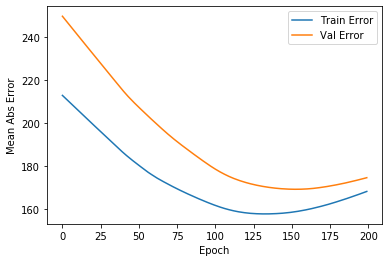

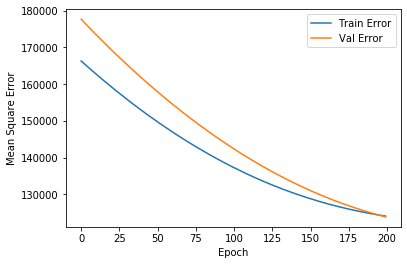

In [90]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [91]:
loss, mae, mse = model.evaluate(X_test_norm, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))


7320/7320 - 0s - loss: 15483.6593 - mae: 86.8112 - mse: 15483.6602
Testing set Mean Abs Error: 86.81


#Prédiction

In [92]:
y_pred = model.predict(X_test_norm).flatten()

In [0]:
test_df['pred']=y_pred

In [94]:
test_df['building_id'].drop_duplicates()

16800267       9
16800432     143
16801891    1127
16801894    1129
16801938    1151
Name: building_id, dtype: uint16

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, '9')

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, '143')

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, '1127')

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, '1129')

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, '1151')

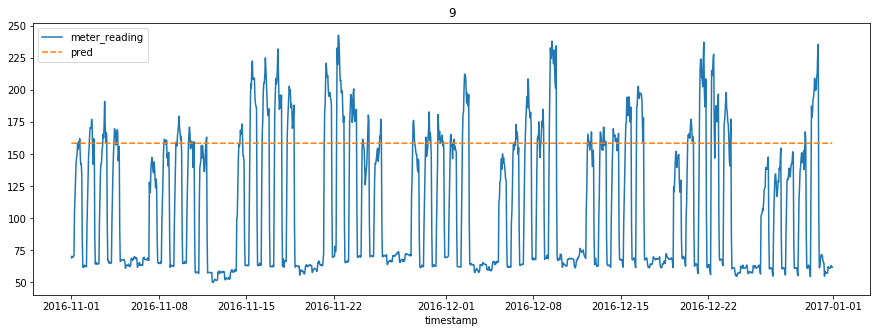

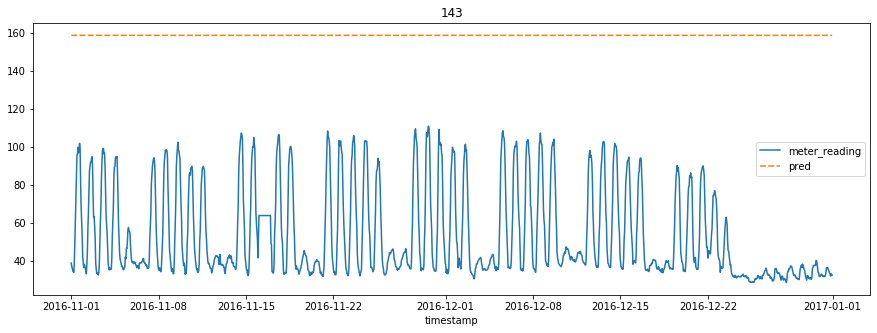

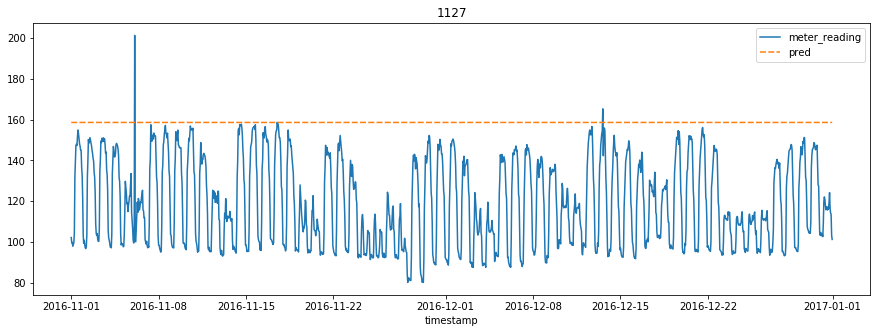

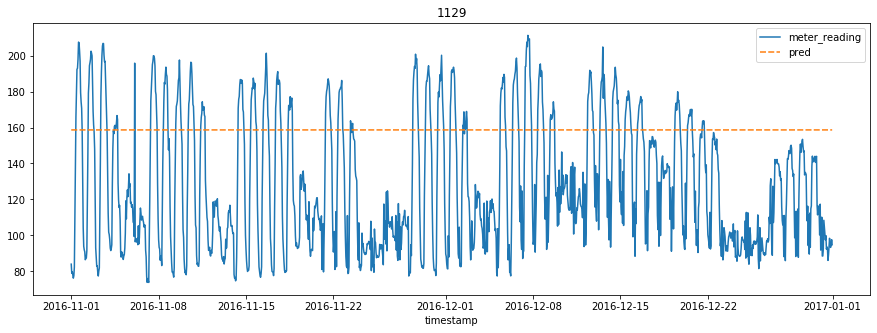

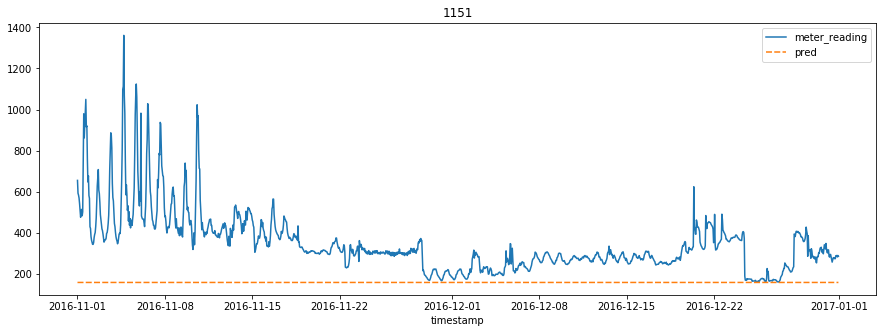

In [95]:
data=test_df.set_index('timestamp')

building_list=test_df['building_id'].unique().tolist()

for b in building_list:
  plt.figure(figsize=(15,5))
  sns.lineplot(data=data[data['building_id']==b][[target_col,'pred']]).set_title(b)

